In [1]:
import re
from os import path
from time import time

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandarallel import pandarallel

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    train_test_split,
    learning_curve,
    cross_val_score,
    RandomizedSearchCV,
)

In [2]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Carregar os dados

## Tweets

In [3]:
# Definir caminho do arquivo
filename = "labeled_data.parquet.gzip"
directory = "data"
filepath = path.join(directory, filename)

# Carregar dados
data = pd.read_parquet(filepath)

# Amostra dos dados
data.sample(10)

,id,text,score,label
66253,1559810938479542274,eu sei que não 😭😭😭,-0.280130,-1
329715,1559969279025479680,minha autoestima tá no céu dps q coloquei essa...,1.355874,1
121931,1559862383396397056,uma das privilegiadas que ganhou 👋,0.416230,1
189236,1559893734476681216,a minha canetinha 😭,-0.093377,-1
897535,1161390341372690433,muito minha cara 😩,-0.368363,-1
145355,1559874212701028352,olha você sendo bem cuidada vida 😍😍,1.355874,1
899034,1161393084661424135,fica melhor a mim q a ele 😌,0.484211,1
436580,1160539615457136641,a falta de manifestação só comprova que eu não...,-0.146058,-1
604974,1160778177289097216,"vou dormir, melhor coisa que eu faço 😴",-0.080780,-1
403757,1160314711466004483,😱 estoque no brasil!! 🇧🇷 sem risco de taxas 🇧🇷...,0.190265,0


## Limpeza de Dados

No modelo Soma das Frequencias*, precisamos saber a quantidade de determinadas palavras que aparecem em tweets positivos, negativos e neutros.

Removeremos as Stopwords (palavras que não adicionam muito significado ao texto).

Para melhorar o modelo, utilizaremos o Stemming, que visa remove alguns [afixos](https://pt.wikipedia.org/wiki/Afixo) das palavras. Exemplo: papel gramatical, tempo, morfologia derivacional, deixando apenas o radical da palavra.
Assim, contaremos apenas os radicais das palavras em vez de suas derivações.

Referências:

- [StopWords](https://en.wikipedia.org/wiki/Stop_word)
- [Stemming](https://en.wikipedia.org/wiki/Stemming)

In [4]:
def preprocess_data(string, stopwords, stemmer=None):

    # Remover os Emojis e Pontuações
    string_tratada = re.sub("\W", " ", string)

    # Remover stopwords
    string_tratada = " ".join(
        [
            substring
            for substring in string_tratada.split()
            if substring not in stopwords
        ]
    )

    # Stemming
    if stemmer:
        string_tratada = " ".join(
            [stemmer.stem(substring) for substring in string_tratada.split()]
        )

    # Remover espaços extras
    string_tratada = re.sub(" +", " ", string_tratada)
    string_tratada = re.sub("(^ )", "", string_tratada)
    string_tratada = re.sub("( $)", "", string_tratada)

    return string_tratada

In [5]:
# Obter as stopwords
portuguese_stopwords = nltk.corpus.stopwords.words("portuguese")

# Inicializar o Stemmer
rlp_stemmer = nltk.stem.RSLPStemmer()

In [6]:
# Mostra das stopwords
pd.Series(portuguese_stopwords).sample(5)

112       me
52     estes
163      sou
1          à
185    tinha
dtype: object

### Demonstração do Tratamento

In [7]:
tweet = data["text"].sample(1).values[0]
tweet_limpo = preprocess_data(tweet, portuguese_stopwords)
tweet_limpo_stemmed = preprocess_data(tweet, portuguese_stopwords, rlp_stemmer)

print("Tweet Original: {}".format(tweet))
print("")
print("Tweet Limpo   : {}".format(tweet_limpo))
print("")
print("Tweet Stemed  : {}".format(tweet_limpo_stemmed))

Tweet Original: tentar dormir 💪

Tweet Limpo   : tentar dormir

Tweet Stemed  : tent dorm


## Aplicação da Limpeza

In [8]:
data["cleaned"] = data["text"].parallel_apply(
    lambda x: preprocess_data(x, portuguese_stopwords, rlp_stemmer)
)

In [9]:
data.sample(5)

,id,text,score,label,cleaned
164286,1559883044823212035,em que site vai vender? tô nervosa 😭,-0.093377,-1,sit vai vend tô nerv
640810,1160871442914955265,"bom diaaa, quero esse domingo! 💕",0.632917,1,bom diaa quer doming
278073,1559948645528752129,saudades de você neguinho do vai fazer mo falt...,-0.722772,-1,saudad negu vai faz mo falt seleç titul amig f...
462997,1160623361652928512,desde sendo cadelinha da maju trindade 😎,0.493369,1,desd send cadel maju trindad
519614,1160701301354897408,sim eu sei 😳,0.017730,0,sim sei


# Engenharia de Atributos: Probabilidade das Ocorrencias

Este modelo é uma variação da Soma das Frequencias.

Vamos transformar o texto numa representação vetorial utilizando a probabilidade da ocorrencia que cada palavra aparece nos tweets por rótulo.

## Gerar dicionário de frequencias

Basicamente criaremos três dicionários, um positivo, um negativo e um neutro.

Cada dicionário terá a soma das vezes que a palavra aparece em seu respectivo rótulo (positivo, negativo ou neutro) em todo o dataset.

### Separar conjuntos de treinamento e teste

Aqui faremos a separação de conjunto de treino e teste.

O dicionário será criado utilizando o conjunto de treino, e posteriormente verificado sua eficácia no conjunto de teste.

In [10]:
X_train, X_test = train_test_split(data, random_state=42)

In [11]:
# Aqui vamos criar nosso dicionário
def gerador_dicionario_tweet(tweet, dicionario):
    words = tweet.split()

    for word in words:
        dicionario[word] = dicionario.get(word, 0) + 1

In [12]:
dicionario_positivo = {}

X_train[X_train["label"] == 1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_positivo)
)

print("Chaves: {}".format(len(dicionario_positivo.keys())))

Chaves: 58366


In [13]:
dicionario_neutro = {}

X_train[X_train["label"] == 0]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_neutro)
)

print("Chaves: {}".format(len(dicionario_neutro.keys())))

Chaves: 27524


In [14]:
dicionario_negativo = {}

X_train[X_train["label"] == -1]["cleaned"].apply(
    lambda x: gerador_dicionario_tweet(x, dicionario_negativo)
)

print("Chaves: {}".format(len(dicionario_negativo.keys())))

Chaves: 32001


### Visualização dos Dicionários

In [15]:
dicionarios = pd.DataFrame(
    [
        pd.Series(dicionario_positivo, name="positivo"),
        pd.Series(dicionario_neutro, name="neutro"),
        pd.Series(dicionario_negativo, name="negativo"),
    ]
).T

In [16]:
dicionarios.sample(10)

,positivo,neutro,negativo
comess,1.0,NaN,NaN
fgv,1.0,2.0,2.0
lain,2.0,NaN,1.0
dahr,NaN,NaN,1.0
shop,31.0,12.0,5.0
fooom,NaN,NaN,1.0
parmes,3.0,NaN,NaN
joinvill,10.0,3.0,2.0
chocked,NaN,1.0,NaN
epílog,NaN,NaN,1.0


## Gerar dicionário das probabilidades

A partir do dicionário de frequencias, vamos gerar o dicionário de probabilidades.

Basicamente, vamos dividir a frequencia que uma palavra aparece em determinado rótulo pela quantidade de palavras naquele rótulo.

Porém, para evitar que tenhamos probabilidade zero, aplicaremos uma Suavização Laplaciana.

In [17]:
def gerar_probabilidades(serie, total_ocorrencias_dimensao, tamanho_vocabulario):
    serie = serie.fillna(0)
    return (serie + 1) / (total_ocorrencias_dimensao + tamanho_vocabulario)

In [18]:
dicionarios["positivo"] = gerar_probabilidades(
    dicionarios["positivo"], dicionarios["positivo"].sum(), dicionarios.shape[0]
)

In [19]:
dicionarios["negativo"] = gerar_probabilidades(
    dicionarios["negativo"], dicionarios["negativo"].sum(), dicionarios.shape[0]
)

In [20]:
dicionarios["neutro"] = gerar_probabilidades(
    dicionarios["neutro"], dicionarios["neutro"].sum(), dicionarios.shape[0]
)

### Visualização do Dicionário

In [21]:
dicionarios.sample(10)

,positivo,neutro,negativo
yulsic,4.469485e-07,0.000002,1.820441e-06
schuasnegg,4.469485e-07,0.000002,1.820441e-06
gahahah,4.469485e-07,0.000003,9.102204e-07
heinj,4.469485e-07,0.000005,9.102204e-07
noop,2.234743e-06,0.000003,9.102204e-07
desencr,4.469485e-07,0.000003,9.102204e-07
esdr,2.234743e-06,0.000002,1.820441e-06
fofoss,4.469485e-06,0.000002,1.820441e-06
gzu,4.469485e-07,0.000006,9.102204e-07
rtil,4.469485e-07,0.000003,9.102204e-07


## Gerar feature vector

Aqui nós transformaremos os textos em um vetor para podermos utilizá-los em um aprendizado supervisionado.

Nosso vetor será representado em três dimensões, uma para positivo, uma para negativo e outro para neutro.

O valor de cada dimensão é definido como o somatório das frequencias de cada palavra do tweet no dicionário da dimensão (positivo, negativo, neutro)

In [22]:
def gerar_feature_vector(string, df):
    tokens = string.split()

    # Calcula o valor de cada dimensão do vetor
    feature_positiva = sum([df["positivo"].get(word, 0) for word in tokens])
    feature_neutra = sum([df["neutro"].get(word, 0) for word in tokens])
    feature_negativa = sum([df["negativo"].get(word, 0) for word in tokens])

    return pd.Series(
        [feature_positiva, feature_neutra, feature_negativa],
        index=["positiva", "neutra", "negativa"],
    )

### Demonstração da Geração do Feature Vector

In [23]:
tweet = X_train["cleaned"].sample(1).values[0]
feature_vector = gerar_feature_vector(tweet, dicionarios)

print("Tweet: {}".format(tweet))
feature_vector

Tweet: q lav louç


positiva    0.006948
neutra      0.008362
negativa    0.012204
dtype: float64

### Aplicar a Geração do Feature Vector em todo o Dataset de Treino

In [24]:
# Gerar Features Train
features_train = X_train["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(x, dicionarios)
)
features_train["label"] = X_train["label"]

In [25]:
features_train.sample(5)

,positiva,neutra,negativa,label
875203,0.025211,0.020843,0.025489,1
663536,0.016251,0.014755,0.021057,1
437272,0.000900,0.000917,0.000583,1
579418,0.000000,0.000000,0.000000,1
784172,0.000261,0.000299,0.000197,1


In [26]:
X_features_train = features_train[["positiva", "neutra", "negativa"]]
X_features_train.sample(5)

,positiva,neutra,negativa
350966,0.006528,0.006563,0.006747
781790,0.008181,0.009875,0.010908
104254,0.002061,0.002972,0.002814
128812,0.002439,0.003611,0.007046
902691,0.036897,0.037960,0.042333


In [27]:
y_features_train = features_train["label"]
y_features_train.sample(5)

265042    0
834111    1
390438   -1
758831    0
231240    1
Name: label, dtype: int64

### Aplicar a Geração do Feature Vector em todo o Dataset de Teste

In [28]:
# Gerar Features Teste
features_test = X_test["cleaned"].parallel_apply(
    lambda x: gerar_feature_vector(x, dicionarios)
)
features_test["label"] = X_test["label"]

In [29]:
features_test.sample(5)

,positiva,neutra,negativa,label
617268,0.000185,0.000475,1.702112e-04,-1
232167,0.000073,0.000005,9.102204e-07,1
406991,0.000000,0.000000,0.000000e+00,1
817055,0.006490,0.000795,1.121392e-03,1
578863,0.010055,0.006836,7.075143e-03,1


In [30]:
X_features_test = features_test[["positiva", "neutra", "negativa"]]
X_features_test.sample(5)

,positiva,neutra,negativa
210823,0.002265,0.002764,0.003412
366596,0.026933,0.025638,0.030146
517342,0.014675,0.014477,0.018097
182560,0.007239,0.001655,0.002890
413771,0.020503,0.010643,0.011396


In [31]:
y_features_test = features_test["label"]
y_features_test.sample(5)

520534    0
493346    0
432866   -1
586589    0
318201    1
Name: label, dtype: int64

## Feature Scaling

Aqui vamos normalizar os dados utilizando o Standard Scaler


Referências:
 - [https://en.wikipedia.org/wiki/Normalization_(statistics)](https://en.wikipedia.org/wiki/Normalization_(statistics))
 - [https://en.wikipedia.org/wiki/Standard_score](https://en.wikipedia.org/wiki/Standard_score)
 - [https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling](https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling)

In [32]:
# Inicializar o Scaler
scaler = StandardScaler()

# Treinar o Scaler
scaler.fit(X_features_train)

StandardScaler()

In [33]:
# Transformar o conjunto de treinamento
transformed = scaler.transform(X_features_train)

# Gerar um dataframe com a saída do scaler
X_features_train_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_train_scaled.sample(5)

,positiva,neutra,negativa
197845,-0.904585,-0.888395,-0.890041
96984,-0.446348,-0.381041,-0.364526
341843,0.188440,-0.353804,-0.253275
309171,-0.903373,-0.844074,-0.864826
339827,-0.408510,-0.351064,-0.503752


In [34]:
transformed = scaler.transform(X_features_test)

# Gerar um dataframe com a saída do scaler
X_features_test_scaled = pd.DataFrame(transformed, columns=scaler.feature_names_in_)

# Amostra
X_features_test_scaled.sample(5)

,positiva,neutra,negativa
210769,-0.572681,-0.540919,-0.535362
36034,-0.230894,-0.821994,-0.719568
149255,-0.001078,-0.042590,-0.108017
104117,-0.939226,-0.915149,-0.905664
21018,-0.745594,-0.734319,-0.721748


# Learning


## Baseline Score

Aqui vamos, criar um score de base. Ou seja, o resultado que conseguiriamos com o menor esforço possível (que é atribuir indiscriminadamente qualquer valor)

Referências:
- [https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [35]:
# Assumindo tudo como 0
score_assumindo_tudo_neutro = f1_score(
    y_features_train, [0 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_neutro * 100))

F-Score: 3.64%


In [36]:
# Assumindo tudo como -1
score_assumindo_tudo_negativo = f1_score(
    y_features_train, [-1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_negativo * 100))

F-Score: 11.62%


In [37]:
# Assumindo tudo como 1
score_assumindo_tudo_positivo = f1_score(
    y_features_train, [1 for _ in y_features_train], average="weighted"
)

print("F-Score: {:.2f}%".format(score_assumindo_tudo_positivo * 100))

F-Score: 43.03%


In [38]:
# Baseline Score
baseline_score = np.max(
    [
        score_assumindo_tudo_neutro,
        score_assumindo_tudo_negativo,
        score_assumindo_tudo_positivo,
    ]
)

print("F-Score: {:.2f}%".format(baseline_score * 100))

F-Score: 43.03%


## Logistic Regression

Referências:
- [https://en.wikipedia.org/wiki/Logistic_regression](https://en.wikipedia.org/wiki/Logistic_regression)
- [https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [39]:
log = LogisticRegression(random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search](https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search)

In [40]:
params = {
    "C": [
        0.47,
        0.53,
        0.59,
        0.61,
        0.67,
        0.71,
        0.73,
        0.79,
        0.83,
        0.89,
        0.97,
        1,
        2,
        3,
        5,
        7,
        9,
        11,
        13,
        17,
        19,
        21,
    ],
    "tol": [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3],
}

clf = RandomizedSearchCV(log, params, scoring="f1_weighted", n_jobs=-1, random_state=42)
clf.fit(X_features_train_scaled, y_features_train)

print("Best F-Score: {:.2f}%".format(clf.best_score_ * 100))

Best F-Score: 52.12%


In [41]:
classifier = clf.best_estimator_

#### Comparação com Métrica base

In [42]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(clf.best_score_ * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - clf.best_score_) * 100))

Score Baseline : 43.03%
Score Modelo   : 52.12%
Diferença      : 9.10%


### Performance no Conjunto de Treino

In [43]:
y_pred = classifier.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 52.12%


### Curva de Aprendizado

In [44]:
def plot_learning_curve(estimator, X, y, scoring):

    plt.figure(figsize=(8, 6))
    plt.title("Learning Curve")

    plt.xlabel("Training examples")
    plt.ylabel("Score: {}".format(scoring))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.ylim(round(min([np.min(train_scores), np.min(test_scores)]), 2) - 0.01, 1.01)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )

    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")

    return plt

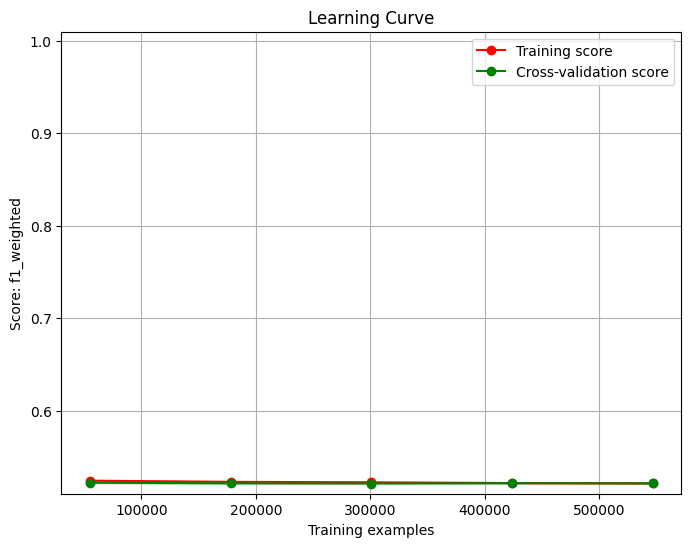

In [45]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Random Forest

Referências:
- [https://en.wikipedia.org/wiki/Random_forest](https://en.wikipedia.org/wiki/Random_forest)
- [https://scikit-learn.org/stable/modules/ensemble.html#forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [46]:
rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

In [47]:
s1 = time()
scores = cross_val_score(
    rf, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
rf_score = scores.mean()

s2 = time()
print("Elapsed Time: ", int(s2 - s1), "seconds")

print("F-Score: {:.2f}%".format(rf_score * 100))

Elapsed Time:  101 seconds
F-Score: 58.92%


In [48]:
rf.fit(X_features_train_scaled, y_features_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=4,
                       n_estimators=200, n_jobs=-1, random_state=42)

### Otimização de Hyperparametros

Nesse passo, vamos tentar encontrar a melhor combinação de hyperparametros para o modelo

Referências:

- [https://scikit-learn.org/stable/modules/grid_search.html#randomized-parameter-search]

In [49]:
# Codigo
# rf = RandomForestClassifier(random_state = 42, n_jobs = -1)
# params = {
#   'n_estimators': [100,200,300],
#   'min_samples_split': [2,3,4,5],
#   'min_samples_leaf': [1,2,3,4],
# }

# clf = RandomizedSearchCV(rf, params, scoring='f1_weighted', random_state=42)
# clf.fit(X_features_train_scaled, y_features_train)

# print("Best F-Score: {:.2f}%".format(clf.best_score_*100))

In [50]:
# clf.best_params_
print({"n_estimators": 200, "min_samples_split": 4, "min_samples_leaf": 2})

{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2}


In [51]:
# rf = clf.best_estimator_

#### Comparação com Métrica base

In [52]:
print("Score Baseline : {:.2f}%".format(baseline_score * 100))
print("Score Modelo   : {:.2f}%".format(rf_score * 100))
print("Diferença      : {:.2f}%".format(np.abs(baseline_score - rf_score) * 100))

Score Baseline : 43.03%
Score Modelo   : 58.92%
Diferença      : 15.90%


### Performance no Conjunto de Treino

In [53]:
y_pred = rf.predict(X_features_train_scaled)
score = f1_score(y_features_train, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 90.28%


### Curva de Aprendizado

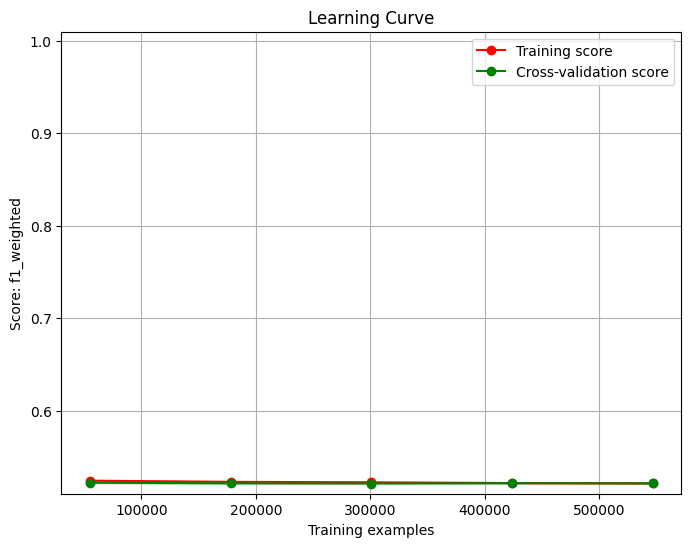

In [54]:
plt = plot_learning_curve(
    classifier, X_features_train_scaled, y_features_train, scoring="f1_weighted"
)
plt.show()

## Validação em conjunto de Teste

In [55]:
y_pred = rf.predict(X_features_test_scaled)
score = f1_score(y_features_test, y_pred, average="weighted")
print("F-Score: {:.2f}%".format(score * 100))

F-Score: 58.73%


### Preditos Positivos

In [56]:
preditos_positivos = X_test[y_pred == 1]

#### Falso Positivo -> Negativo

In [57]:
preditos_positivos[preditos_positivos["label"] == -1]["text"].sample(10).values

array(['são os brações que não deixam ele completar o coração 😔',
       'maldita carinha vai dize se n é o amor da mia vida 😭',
       'que pena que não dá tempo pra tu vim junto😔',
       'as homenagens continuam😭',
       'não! todos tem a ver com algum elemento kkk exceto hatsheput, que foi uma homenagem a uma rainha egípcia pela qual eu estava obcecada na época 💀',
       'tão se juntando pra meter o pau em mim 😔😤',
       'minhas aulas começam amanhã, adeus férias 😭',
       'eu só queria um feriado 😩',
       'nao ... 😔 mas tem um cara cara aí que as vezes tenta ser responsável pra se mostrar um pai presente pras pessoas ne...',
       'só pq te dei o gatinho 😔'], dtype=object)

#### Falso Positivo -> Neutro

In [58]:
preditos_positivos[preditos_positivos["label"] == 0]["text"].sample(10).values

array(['qualquer coisa que eu falo pra minha mãe ela fala chega do guarujá vem embora logo pra são paulo eu fico pensativa o mês inteiro 😩😂😂',
       'cometo sempre e não tenho vergonha 😂',
       'deyverson é o novo treinador do vozão! ⚫️⚪️ o comandante e sua comissão chegam quinta-feira na capital cearense. bem-vindo, professor! 👊 cearásc vozão',
       'o famoso nunca mais aconteceu novamente 😶😂',
       'que que aconteceu? tava lavando o cabelo 😱',
       'prendi a alça da mochila três vezes ontem no banco dos ônibus q inferno q foi p tirar 😅',
       'bom diaaa, o sol já nasceu lá na fazendinhaaa 💥🌞',
       'claro, tu brinca mt 😂',
       'krai, mabi prozeando com geral e eu pra la e pra ca balones kkk 🔥',
       '👀 partiu ?? 🤣🤣🤪'], dtype=object)

#### Verdadeiro Positivo

In [59]:
preditos_positivos[preditos_positivos["label"] == 1]["text"].sample(10).values

array(['não mesmo 😌', 'boom dia ✨🤞🏼',
       'e há boatos q o presidente está numa pior 🤔🤔😂😂🥂🥂',
       'bom diaaa com jesus ❤️\u200d🔥❤️\u200d🔥❤️\u200d🔥',
       'pai é amor, cuidado, proteção.. pai é bênção!! papai nota . ❤',
       'ultimos destaques 🤨 bolsonaro resolveu suspender o uso de radares ... 😉 temendo empate, comissão que sabatinará ed…',
       'essa vergonha eu não passei 💪',
       'ah, vá!!! conta uma novidade agora!!! 😋😋😋',
       'ontem eu fui dormir com um "boa noite vida" 😻',
       'uma mulher com sua skin care completa não quer guerra com ninguém 💖'],
      dtype=object)

### Preditos Negativos

In [60]:
preditos_negativos = X_test[y_pred == -1]

#### Falso Negativo -> Positivo

In [61]:
preditos_negativos[preditos_negativos["label"] == 1]["text"].sample(10).values

array(['bem q a minha sala tava precisando de uma animação, uma treta não faz mal a ninguém 😜',
       'que sono 😴💤💤 vou dormir mais um pouco',
       'eu tava com saudades do meu querido twitter 💙',
       'assistindo tudo em inglês agora!💜',
       'depende de qual, tem umas que são horríveis (aquelas gigante) mas tem umas que são fantásticas 😍',
       'se arranca a cursar 💪', 'to nem aí pra porra nenhuma 😌',
       '😚 biquinho', 'eu só queria ter pai presente só isso 😌',
       'no problem, nana 💜'], dtype=object)

#### Falso Negativo -> Neutro

In [62]:
preditos_negativos[preditos_negativos["label"] == 0]["text"].sample(10).values

array(['é uns pobre mais fudido q eu apoiando o bolsonaro, q eu fico 🤔🤔🤔😳🤨🤨',
       'ma’am 😂', 'acho q meu celular chega amanhã 👀👀',
       'tenho um aluno que é igualzinho esse que tá querendo brigar 🤣🤣 passo um dobrado quando isso acontece 😰',
       'é o que tô pensando? 👀',
       'tenho medo de dormi sozinha nessa casa 😢', 'qr ser o 😳',
       'cara ninguém me ensinou agr querem me cobrar 😥',
       'pensar nisto deixa me triste 😢',
       'tô com você nessa corrida deputado para são paulo .. bora bora pq agora não tem mas volta 🔥'],
      dtype=object)

#### Verdadeiro Negativo

In [63]:
preditos_negativos[preditos_negativos["label"] == -1]["text"].sample(10).values

array(["vim mais no shopping pra comer no mcdonald's vai lá e fecha afz vou ter que comer um burger king agora 💔",
       "passei a pasta d'água no pescoço de danilo ele tá reclamando mas ainda tadinho 😔",
       'você é romântico(a)? - solteira 🤪 - simm mas sou timida - sim - sim 😔 - acho q sim viu - sim kk - o…',
       'tadinho do meu neném ta enjoadinho 💔',
       'a única coisa q eu precisava mesmo era da mh filha comigo 😭',
       'saudades sextou em riolândia 😩', 'que dor no corpo 😔', 'huhuu😭',
       'n aguento mais sentir dor de cabeça 😔', 'volta olimpíadas😭'],
      dtype=object)

### Preditos Neutros

In [64]:
preditos_neutros = X_test[y_pred == 0]

#### Falso Neutro -> Positivo

In [65]:
preditos_neutros[preditos_neutros["label"] == 1]["text"].sample(10).values

array(['semana de gincana na escola da sophia, já sabem quem vai ganhar a medalha né ? 😂💛',
       'amizades novas, da um fv aí que eu chamo!!! 😄',
       'ummm empanadillaaasss bd ❤️😘☕', 'no terceiro ✌',
       'alexynha dos predinhos 😎', 'uia ele todo apaixonadinho 😍',
       'o auge da maturidade é ter vontade de falar mil coisas e ficar caladinha. porque o silêncio vence e tem verdades que não precisam ser ditas !😉',
       'vitória, sai zica 🙌', 'assim de saúde 😀',
       'o dinheiro move o mundo 🎶'], dtype=object)

#### Falso Neutro -> Negativo

In [66]:
preditos_neutros[preditos_neutros["label"] == -1]["text"].sample(10).values

array(['um gajo sai de arouca é logo bar aberto na zénite 😒',
       '😒 . alguém?', 'o medico é bue hot tf😭',
       'foi horrivel a imagem continua na minha mente 😔',
       'não sei oque eu ainda estou fazendo acordada, vou acorda : pra ir pro curso amanhã 😪',
       'eu tinha visto 😭', 'magui 😭😭😭',
       'essa vida de adulto não é fácil 😭',
       'aa não lembrei que você ia cortar por agora😔',
       'nem fala cr, como q pode 😡'], dtype=object)

#### Verdadeiro Neutro

In [67]:
preditos_neutros[preditos_neutros["label"] == 0]["text"].sample(10).values

array(['crlh pensei q ñ ia conseguir chegar a tempo kkk a lux me salvou 😅',
       'toca aqui! ✋', 'eu no futo 😅', 'no vex 😂', '😂 sor-praais!',
       'a minha familia é inteirinha atleticana, pense 😅',
       'alguém teria um pacote de macarrão e um molho de tomate pra eu fazer sopa pra mim e pra minha mãezinha por favor 😭? estou doente, tenho câncer em estado avançado, perdi parte da visão e audição 😔 moro com a minha mãe que já é idosa, peço doações por nós 🙏',
       'solteira que se diz??? 😅',
       'pensei que a cabeça do cara fosse o joelho dela 😥',
       'missão do dia: fazer essa imagem chegar aos cantos do país, através de todas as redes, e escrever aqui no twiter a frase: bolsonaro usa deus. deus usa lula! 👊🇧🇷'],
      dtype=object)